### Business Objective

A US-based housing company named Surprise Housing has decided to enter the Australian market.

The company is looking at prospective properties to buy to enter the market. The aim of the analysis is to build a regression model using regularization to predict the actual value of the prospective properties and decide whether to invest in them or not.

<b>Business Goal:</b>

- Predict variables that are significant in predicting the price of a house
- Predict how good those variables describe the price of a house

In [1]:
#Import the requried libs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#sklearn libs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [2]:
#Loading the dataset and read the data

data = pd.read_csv('train.csv')
print(data.shape)

(1460, 81)


### Exploratory Data Analysis

Inspect and clean the dataset

In [3]:
#Check the dataframe info
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
#check few rows to get a glimpse of the data
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


There could be duplicate rows in the dataset, let's try to clear those.

In [5]:
#drop duplicates
data = data.drop_duplicates()

#check the shape of the dataset after dropping the duplicates
print(data.shape)

#Remove any additional white spaces in the data
data = data.rename(columns=lambda x: x.strip())

(1460, 81)


Let's check if there are missing or null values in the dataset

In [6]:
# Check for null values
missing_col_percent= round(100*data.isnull().sum()/len(data.index),2)
missing_cols = pd.DataFrame(missing_col_percent[missing_col_percent!=0])
print(missing_cols)

                  0
LotFrontage   17.74
Alley         93.77
MasVnrType     0.55
MasVnrArea     0.55
BsmtQual       2.53
BsmtCond       2.53
BsmtExposure   2.60
BsmtFinType1   2.53
BsmtFinType2   2.60
Electrical     0.07
FireplaceQu   47.26
GarageType     5.55
GarageYrBlt    5.55
GarageFinish   5.55
GarageQual     5.55
GarageCond     5.55
PoolQC        99.52
Fence         80.75
MiscFeature   96.30


There are many columns that have NA values in them. 

- Further, based on the data description there are some columns where missing values is anticipated
- Thus, NA values can be replaced with 'None' in those columns

In [7]:
# Impute NA with None for the below columns
special_cols = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature','Electrical']
for column in special_cols:
    data[column]= data[column].fillna('None')

Columns with either a single value or all unique values do not help in analysis. So, drop such columns

In [8]:
# Removing columns with a single value in data
uniques = data.apply(lambda x:x.nunique())
data = data.drop(uniques[uniques < 2].index, axis = 1)
print("Dataset Shape after dropping columns with single value in data", data.shape)

# Removing columns where all values are unique, e.g.. Id column
data = data.drop(uniques[uniques == len(data)].index, axis = 1)
print("Dataset Shape after dropping columns with all unique values", data.shape)


Dataset Shape after dropping columns with single value in data (1460, 81)
Dataset Shape after dropping columns with all unique values (1460, 80)


So, we can observe that there are now 80 columns to analyse. Now, let's see if there are any anomalies in the dataset

In [9]:

#Describe the percentiles for columns in the dataset
data.describe(percentiles=[.25,.5,.75,.90,.95,.99])


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
90%,120.000000,96.000000,14381.700000,8.000000,7.000000,2006.000000,2006.000000,335.000000,1065.500000,117.200000,...,262.000000,130.000000,112.000000,0.000000,0.000000,0.000000,0.000000,10.000000,2010.000000,278000.000000
95%,160.000000,107.000000,17401.150000,8.000000,8.000000,2007.000000,2007.000000,456.000000,1274.000000,396.200000,...,335.000000,175.050000,180.150000,0.000000,160.000000,0.000000,0.000000,11.000000,2010.000000,326100.000000
99%,190.000000,141.000000,37567.640000,10.000000,9.000000,2009.000000,2009.000000,791.920000,1572.410000,830.380000,...,505.460000,285.820000,261.050000,168.000000,268.050000,0.000000,700.000000,12.000000,2010.000000,442567.010000


It can be observed that some columns clearly have outliers e.g.. SalePrice, LotArea, MasVnrArea, WoodDeckSF, OpenPorchSF etc..

To remove the skewness in the dataset, let's try to analyse the categorical and numerical columns separately. 

- For the categorical columns, remove those that have more than 85% data associated to one value.

In [10]:
#Remove any column that has one value with more than 85% repition as this column would be skewed

# Function to get the columns that have count of one value more than a given percent
def GetColumnsWithSkewness(percent, objectType):
    column = []
    columns = data.select_dtypes(include=objectType)
    for col in columns:
        if(data[col].value_counts().max() >= int(len(data)*percent)):
            column.append(col)
    return column

In [11]:

#Remove cols skewness and check the data
cat_cols_to_remove = GetColumnsWithSkewness(0.85,['object'])
data = data.drop(cat_cols_to_remove, axis = 1)
print(data.shape)
data.head()

(1460, 59)


,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice
0,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,...,0,0,0,0,None,0,2,2008,Normal,208500
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,...,0,0,0,0,None,0,5,2007,Normal,181500
2,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,...,0,0,0,0,None,0,9,2008,Normal,223500
3,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,...,272,0,0,0,None,0,2,2006,Abnorml,140000
4,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,...,0,0,0,0,None,0,12,2008,Normal,250000


With this, our columns are now reduced to 59 from 80.

In [12]:
# Check if there are any NA values present in the categorical columns
data.select_dtypes(include='object').isnull().sum()[data.select_dtypes(include='object').isnull().sum()>0]

Series([], dtype: int64)

As there no more NA values in the categorical columns and the skewness is also reduced, let's try to reduce the same in the Numerical columns

In [13]:

#check if there are any null values in the numerical columns
data.select_dtypes(include=['int64','float']).isnull().sum()[data.select_dtypes(include=['int64','float']).isnull().sum()>0]


LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [14]:
# Impute the NA values with median for the above columns

data['LotFrontage'] = data['LotFrontage'].replace(np.nan, data['LotFrontage'].median())
data['MasVnrArea'] = data['MasVnrArea'].replace(np.nan, data['MasVnrArea'].median())
data['GarageYrBlt']=data['GarageYrBlt'].replace(np.nan, data['MasVnrArea'].median())

In [15]:
# Check nulls if any
data.select_dtypes(include=['int64','float']).isnull().sum()[data.select_dtypes(include=['int64','float']).isnull().sum()>0]

Series([], dtype: int64)

As we can observe there are no more Numerical columns with NA values. Now, let's try to remove skewness from the numerical columns

In [16]:
#Get numerical columns with skewness 
num_cols_to_remove = GetColumnsWithSkewness(0.85,['int64','float'])
data = data.drop(num_cols_to_remove, axis = 1)
print(data.shape)
data.head()

(1460, 50)


,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,...,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,Fence,MoSold,YrSold,SaleCondition,SalePrice
0,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,...,RFn,2,548,0,61,None,2,2008,Normal,208500
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,...,RFn,2,460,298,0,None,5,2007,Normal,181500
2,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,...,RFn,2,608,0,42,None,9,2008,Normal,223500
3,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,...,Unf,3,642,0,35,None,2,2006,Abnorml,140000
4,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,...,RFn,3,836,192,84,None,12,2008,Normal,250000


After the columns with skewness removed, we have 50 columns to analyse

In [17]:
#Check missing values

missing_data = round(100*(data.isnull().sum()/len(data.index)), 2)
print(missing_data)

MSSubClass       0.0
MSZoning         0.0
LotFrontage      0.0
LotArea          0.0
LotShape         0.0
LotConfig        0.0
Neighborhood     0.0
BldgType         0.0
HouseStyle       0.0
OverallQual      0.0
OverallCond      0.0
YearBuilt        0.0
YearRemodAdd     0.0
RoofStyle        0.0
Exterior1st      0.0
Exterior2nd      0.0
MasVnrType       0.0
MasVnrArea       0.0
ExterQual        0.0
Foundation       0.0
BsmtQual         0.0
BsmtExposure     0.0
BsmtFinType1     0.0
BsmtFinSF1       0.0
BsmtUnfSF        0.0
TotalBsmtSF      0.0
HeatingQC        0.0
1stFlrSF         0.0
2ndFlrSF         0.0
GrLivArea        0.0
BsmtFullBath     0.0
FullBath         0.0
HalfBath         0.0
BedroomAbvGr     0.0
KitchenQual      0.0
TotRmsAbvGrd     0.0
Fireplaces       0.0
FireplaceQu      0.0
GarageType       0.0
GarageYrBlt      0.0
GarageFinish     0.0
GarageCars       0.0
GarageArea       0.0
WoodDeckSF       0.0
OpenPorchSF      0.0
Fence            0.0
MoSold           0.0
YrSold       

We can see that there are no more columns with NA or missing data anymore.

In [18]:
#let's check for outliers in the dataset again after columns with skewness removed
data.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,567.240411,...,6.517808,0.613014,1868.739726,1.767123,472.980137,94.244521,46.660274,6.321918,2007.815753,180921.195890
std,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,441.866955,...,1.625393,0.644666,453.697295,0.747315,213.804841,125.338794,66.256028,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,5.000000,0.000000,1958.000000,1.000000,334.500000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,477.500000,...,6.000000,1.000000,1977.000000,2.000000,480.000000,0.000000,25.000000,6.000000,2008.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,808.000000,...,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,8.000000,2009.000000,214000.000000
90%,120.000000,92.000000,14381.700000,8.000000,7.000000,2006.000000,2006.000000,335.000000,1065.500000,1232.000000,...,9.000000,1.000000,2006.000000,3.000000,757.100000,262.000000,130.000000,10.000000,2010.000000,278000.000000
95%,160.000000,104.000000,17401.150000,8.000000,8.000000,2007.000000,2007.000000,456.000000,1274.000000,1468.000000,...,10.000000,2.000000,2007.000000,3.000000,850.100000,335.000000,175.050000,11.000000,2010.000000,326100.000000
99%,190.000000,137.410000,37567.640000,10.000000,9.000000,2009.000000,2009.000000,791.280000,1572.410000,1797.050000,...,11.000000,2.000000,2009.000000,3.000000,1002.790000,505.460000,285.820000,12.000000,2010.000000,442567.010000


#### Univariate Analysis

So, looks like there are still some columns that have outliers. 

Let's try to visualize these columns to confirm our observation

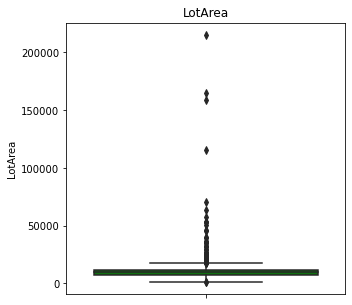

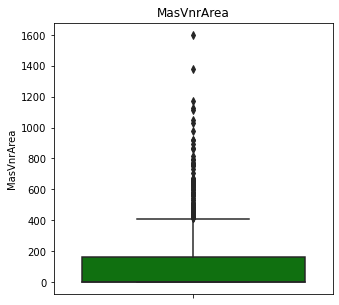

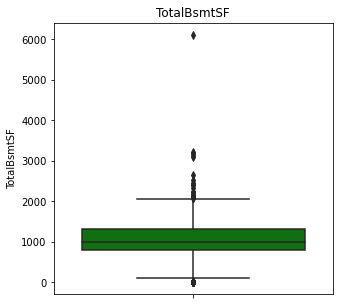

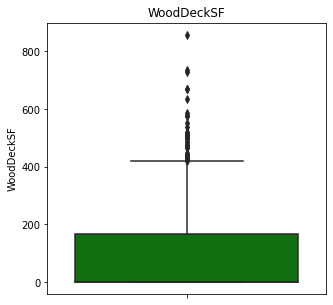

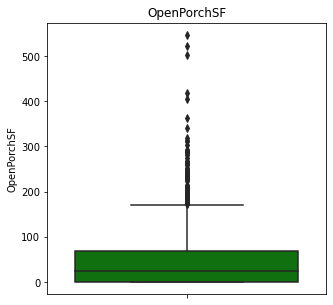

In [19]:
#plot the columns that have outliers
cols = ['LotArea','MasVnrArea','TotalBsmtSF','WoodDeckSF','OpenPorchSF']

for col in cols:
    plt.figure(figsize=(5,5))
    plt.title(col)
    sns.boxplot(y=col,data=data,color='g')    
    plt.show()

The columns have outliers in them. So, let's just use only the 98th percentile of data for our analysis as outliers can influence our prediction

In [20]:
# Removing data beyond 98% for the numerical_cols
for col in cols:
    percentileVal = data[col].quantile(0.98)
    data = data[data[col] < percentileVal]

# Check the percentage of data retained
print("Percent of data retained:", round(100*(len(data)/1460),2))    

Percent of data retained: 90.21


With around 90% of data retained, we still have sufficient data to analyse and also have avoided the outliers.

#### Data Transformation

Let's create a new column to check if the building is remodelled. We can consider the existing 'YearBuilt' and 'YearRemodAdd' to create this new column.

In [21]:
#create a 'IsBldgRemodelled' column

def IsBldgRemodelled(val):
    if(val['YearBuilt'] == val['YearRemodAdd']):
        return 0
    elif(val['YearBuilt'] < val['YearRemodAdd']):
        return 1
    else:
        return 2
    
data['IsBldgRemodelled'] = data.apply(IsBldgRemodelled, axis=1)
data.head()    

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,Fence,MoSold,YrSold,SaleCondition,SalePrice,IsBldgRemodelled
0,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,...,2,548,0,61,None,2,2008,Normal,208500,0
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,...,2,460,298,0,None,5,2007,Normal,181500,0
2,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,...,2,608,0,42,None,9,2008,Normal,223500,1
3,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,...,3,642,0,35,None,2,2006,Abnorml,140000,1
4,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,...,3,836,192,84,None,12,2008,Normal,250000,0


In [22]:
# Create a new 'BuildingAge' column and check the age of the building at the time of selling

def RetrieveBuildingAge(val):
    if(val['YearBuilt'] == val['YearRemodAdd']):
        return val['YrSold'] - val['YearBuilt']
    else:
        return val['YrSold'] - val['YearRemodAdd']
       
data['BuildingAge'] = data.apply(RetrieveBuildingAge, axis=1)
data.head()  

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,...,GarageArea,WoodDeckSF,OpenPorchSF,Fence,MoSold,YrSold,SaleCondition,SalePrice,IsBldgRemodelled,BuildingAge
0,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,...,548,0,61,None,2,2008,Normal,208500,0,5
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,...,460,298,0,None,5,2007,Normal,181500,0,31
2,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,...,608,0,42,None,9,2008,Normal,223500,1,6
3,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,...,642,0,35,None,2,2006,Abnorml,140000,1,36
4,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,...,836,192,84,None,12,2008,Normal,250000,0,8


In [23]:
# Similar to the previous transformations, create a new 'HasNewGarage' column to check if the garage is a new one. 
# We can check if the garage is older than year 2000, it's an old garage

def CheckIfNewGarage(val):
    if val < 2000:        
        return 0
    else:   
        return 1
    
data['HasNewGarage'] = data['GarageYrBlt'].apply(CheckIfNewGarage)
data.head() 

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,...,WoodDeckSF,OpenPorchSF,Fence,MoSold,YrSold,SaleCondition,SalePrice,IsBldgRemodelled,BuildingAge,HasNewGarage
0,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,...,0,61,None,2,2008,Normal,208500,0,5,1
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,...,298,0,None,5,2007,Normal,181500,0,31,0
2,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,...,0,42,None,9,2008,Normal,223500,1,6,1
3,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,...,0,35,None,2,2006,Abnorml,140000,1,36,0
4,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,...,192,84,None,12,2008,Normal,250000,0,8,1


With some new columns created, let's delete the original columns. 

In [24]:
data = data.drop(['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'], axis = 1)

Let's visualize the 'SalePrice' column for skewness check

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


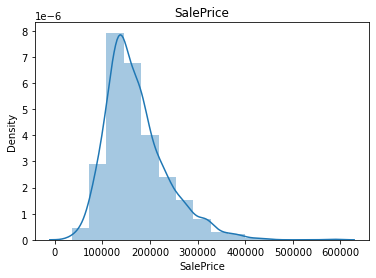

In [25]:
## Visualise the target variable, SalePrice
plt.title('SalePrice')
sns.distplot(data['SalePrice'], bins=15)
plt.show()

We can observe that the plot is left skewed. A log transformation for this column could remove the skewness in the plot

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


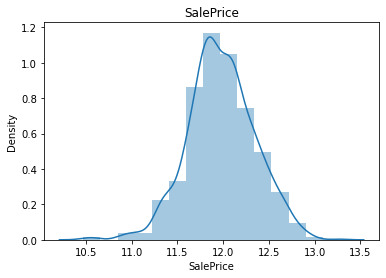

In [26]:
#Perform a log transformation for the column and plot it

data['SalePrice'] = np.log1p(data['SalePrice'])

plt.title('SalePrice')
sns.distplot(data['SalePrice'], bins=15)
plt.show()


We can confirm that the skewness is now reduced with the log transformation.

#### Bivariate Analysis

Let's try to analyse the Target variable against different columns using a pairplot

<Figure size 720x360 with 0 Axes>

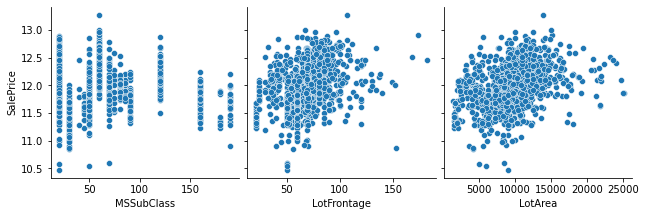

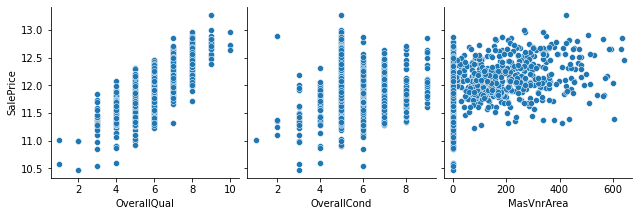

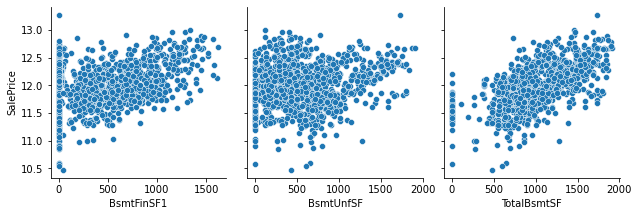

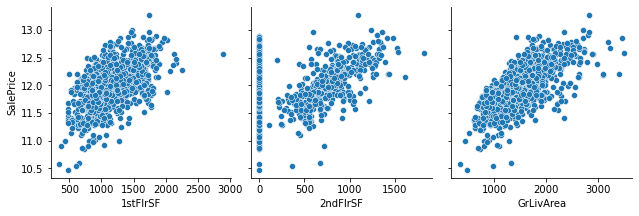

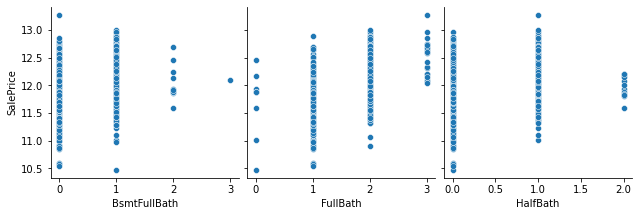

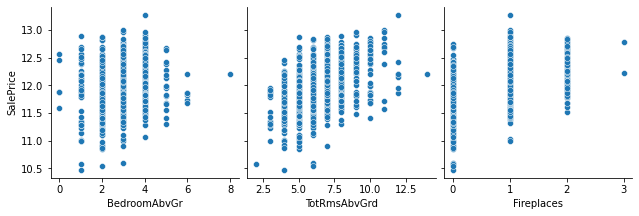

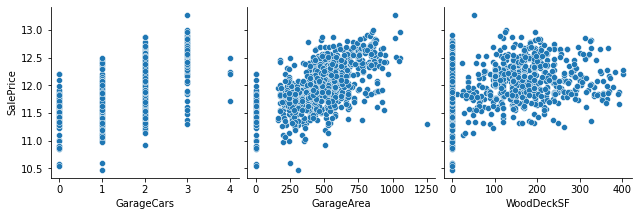

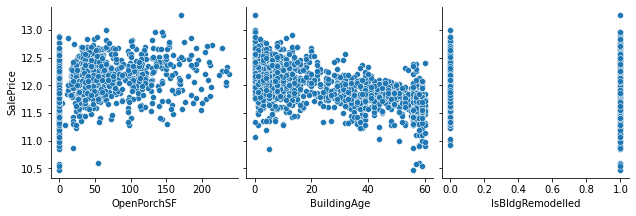

In [27]:
#plot columns using pairplots

plt.figure(figsize=(10,5))
sns.pairplot(data, x_vars=['MSSubClass','LotFrontage','LotArea'], y_vars='SalePrice',height=3,kind='scatter')
sns.pairplot(data, x_vars=['OverallQual', 'OverallCond','MasVnrArea'], y_vars='SalePrice',height=3, kind='scatter')
sns.pairplot(data, x_vars=['BsmtFinSF1', 'BsmtUnfSF','TotalBsmtSF'], y_vars='SalePrice',height=3, kind='scatter')
sns.pairplot(data, x_vars=['1stFlrSF','2ndFlrSF', 'GrLivArea'], y_vars='SalePrice',height=3, kind='scatter')
sns.pairplot(data, x_vars=['BsmtFullBath','FullBath', 'HalfBath'], y_vars='SalePrice',height=3, kind='scatter')
sns.pairplot(data, x_vars=['BedroomAbvGr','TotRmsAbvGrd', 'Fireplaces'], y_vars='SalePrice',height=3, kind='scatter')
sns.pairplot(data, x_vars=['GarageCars','GarageArea', 'WoodDeckSF'], y_vars='SalePrice',height=3, kind='scatter')
sns.pairplot(data, x_vars=['OpenPorchSF','BuildingAge', 'IsBldgRemodelled'], y_vars='SalePrice',height=3, kind='scatter')
plt.show()

It can be observed that there is a certain linear relationship between columsn like TotalBsmtSF, 1stFlrSF and BuildingAge where columns like TotalBsmtSF have a positive correlation and the column BuildingAge has a negative correlation

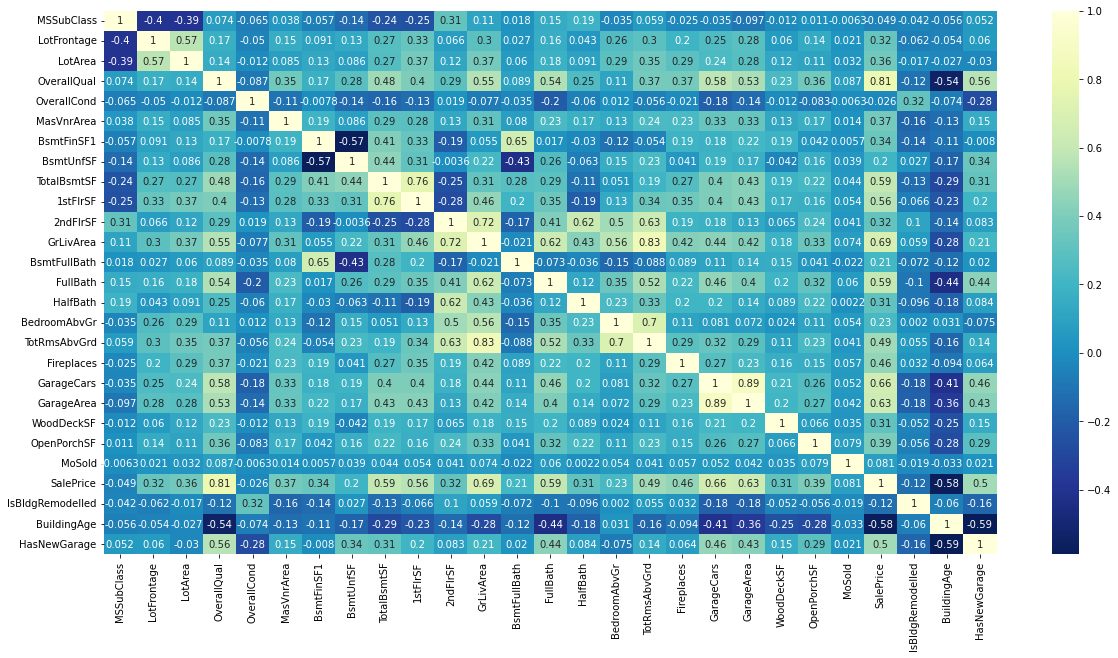

In [28]:
# Create a heatmap to check the correlation between columns
plt.figure(figsize = (20, 10))
sns.heatmap(data.corr(), annot = True, cmap="YlGnBu_r")
plt.show()

Observation:

It can be seen that the columns SalePrice and OverallQual have a very high correlation, similarly GarageCars and GarageArea has a very high correlation score. Though we will not drop any further column at this stage and let our advanced regression techniques decide the columns to select.

#### Dummy Variable Creation

In [29]:
# For the categorical columns, create dummy variables

cat_col_list = ['LotShape','ExterQual','BsmtQual','BsmtExposure','BsmtFinType1','HeatingQC','KitchenQual','FireplaceQu','GarageFinish',\
    'BldgType','HouseStyle','Fence','LotConfig','MasVnrType','SaleCondition', 'MSZoning','Neighborhood','RoofStyle','Exterior1st', \
    'Exterior2nd','Foundation','GarageType','MSSubClass']

for col in cat_col_list:
    dummy_var = pd.get_dummies(data[col], prefix=col, drop_first = True)
    data = pd.concat([data, dummy_var], axis=1)
    data = data.drop([col],axis=1)  # Delete the original columns as they are no more needed

data.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,65.0,8450,7,5,196.0,706,150,856,856,854,...,1,0,0,0,0,0,0,0,0,0
1,80.0,9600,6,8,0.0,978,284,1262,1262,0,...,0,0,0,0,0,0,0,0,0,0
2,68.0,11250,7,5,162.0,486,434,920,920,866,...,1,0,0,0,0,0,0,0,0,0
3,60.0,9550,7,5,0.0,216,540,756,961,756,...,0,1,0,0,0,0,0,0,0,0
4,84.0,14260,8,5,350.0,655,490,1145,1145,1053,...,1,0,0,0,0,0,0,0,0,0


#### Machine Learning - model building

In [30]:
print("Final shape of data to analyse: ",data.shape)

Final shape of data to analyse:  (1317, 175)


In [31]:
# Create the independent and dependent variable
X=data.drop(['SalePrice'],axis=1)
y=data['SalePrice']

In [32]:
#Scale the data and prepare the test & train split
scalar = StandardScaler()
scalar.fit(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=100)

#### Advance Regression techniques 

##### a) Ridge Regression

In [33]:
#Performing Ridge Regression 
params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [34]:
# display the mean scores

cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=500]
cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
21,10.0,-0.069963,-0.082904,1
20,9.0,-0.069671,-0.082945,2
19,8.0,-0.069364,-0.083003,3
22,20,-0.072217,-0.083083,4
18,7.0,-0.069042,-0.083089,5
17,6.0,-0.068705,-0.083239,6
16,5.0,-0.068345,-0.083459,7
15,4.0,-0.067954,-0.083794,8
14,3.0,-0.067514,-0.084297,9
23,50,-0.075938,-0.084425,10


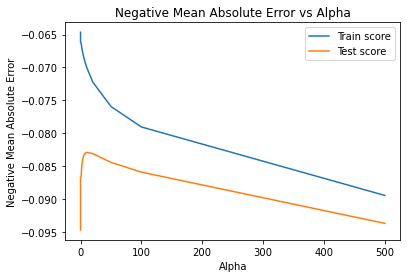

In [35]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('Alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error vs Alpha")
plt.legend(['Train score', 'Test score'], loc='upper right')
plt.show()

In [36]:
# Print the best estimator for lambda
print(ridge_model_cv.best_estimator_)

Ridge(alpha=10.0)


Now that we have the best value for lambda of Ridge Regression with us. Let's predict the test results and check the R2 score and Mean Squared Error

In [37]:
# check the coefficient values with lambda = 10
alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)

# predict
y_train_pred = ridge.predict(X_train)

# Print the r2_score for train and test set
print("R2score for Train set:", metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred_ridge = ridge.predict(X_test)
print("R2score for Test set:", metrics.r2_score(y_true=y_test, y_pred=y_test_pred_ridge))

# Print the mean squared error
print("Mean_squared_error: ", mean_squared_error(y_true=y_test, y_pred=y_test_pred_ridge))


R2score for Train set: 0.9262862373234644
R2score for Test set: 0.8832523561518475
Mean_squared_error:  0.015486973149248687


In [38]:
# Create a dataframe with feature names and their coefficients
df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4)})
df.reset_index(drop=True, inplace=True)
df

,Features,Coefficient
0,LotFrontage,0.0005
1,LotArea,0.0000
2,OverallQual,0.0545
3,OverallCond,0.0410
4,MasVnrArea,-0.0000
...,...,...
169,MSSubClass_90,-0.0108
170,MSSubClass_120,0.0054
171,MSSubClass_160,-0.0328
172,MSSubClass_180,0.0016


So, we see a complex model generated by Ridge Regression with many non-zero coefficients. So, to perform feature selection and get the most important features, let's do an RFE 

In [39]:
# Peform RFE
X_train_ridge = X_train[df.Features]

lm = LinearRegression()
lm.fit(X_train_ridge, y_train)

rfe = RFE(lm)            
rfe = rfe.fit(X_train_ridge, y_train)

In [40]:
# Assign the Features and their coefficient values to a dictionary
df_dict = dict(pd.Series(ridge.coef_.round(4), index = X_train.columns))

# display the top features from dataframe
df = pd.DataFrame(list(zip( X_train_ridge.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
df = df.loc[df['rfe_support'] == True]
df.reset_index(drop=True, inplace=True)

df['Coefficient'] = df['Features'].apply(lambda x: df_dict[x])
df = df.sort_values(by=['Coefficient'], ascending=False)
df = df.head(10)
df

,Features,rfe_support,rfe_ranking,Coefficient
36,SaleCondition_Partial,True,1,0.0797
41,Neighborhood_Crawfor,True,1,0.0728
72,Foundation_PConc,True,1,0.0675
55,Exterior1st_BrkFace,True,1,0.0625
0,OverallQual,True,1,0.0545
35,SaleCondition_Normal,True,1,0.0524
37,MSZoning_FV,True,1,0.0493
1,OverallCond,True,1,0.0410
69,Exterior2nd_Wd Sdng,True,1,0.0383
11,BsmtExposure_Gd,True,1,0.0358


##### b) Lasso Regression

In [41]:
# Perform a Lasso Regression technique
lasso = Lasso()

# list of alphas
params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]}

# cross validation
folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.745e+00, tolerance: 1.024e-02
  model = cd_fast.enet_coordinate_descent(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.964e+00, tolerance: 9.575e-03
  model = cd_fast.enet_coordinate_descent(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.465e+00, toleranc

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.001, 0.002, 0.003, 0.004, 0.005, 0.01]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [42]:
# display the mean scores
lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
3,0.0004,-0.070157,-0.084267,1
4,0.0005,-0.071195,-0.084299,2
2,0.0003,-0.069072,-0.084422,3
1,0.0002,-0.067827,-0.084751,4
5,0.001,-0.075153,-0.085153,5
0,0.0001,-0.066532,-0.086207,6
6,0.002,-0.079495,-0.086838,7
7,0.003,-0.082380,-0.088161,8
8,0.004,-0.084439,-0.089341,9
9,0.005,-0.085945,-0.090575,10


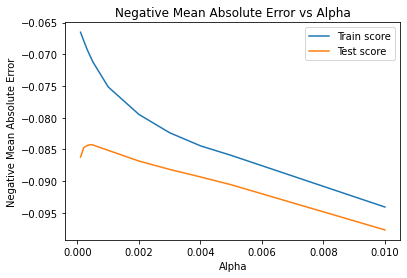

In [43]:
# plotting mean test and train scoes with alpha
lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

# plotting
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('Alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error vs Alpha")
plt.legend(['Train score', 'Test score'], loc='upper right')
plt.show()

In [44]:
# Print the best estimator for lambda
print(lasso_model_cv.best_estimator_)

Lasso(alpha=0.0004)


In [45]:
# check the coefficient values with lambda = 0.0004
alpha = 0.0004

lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train)

# predict
y_train_pred = lasso.predict(X_train)

# Check the r2_score
print("R2score for Train set:", metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred_ridge = lasso.predict(X_test)
print("R2score for Test set:", metrics.r2_score(y_true=y_test, y_pred=y_test_pred_ridge))

# Check the mean squared error
print("Mean_squared_error: ", mean_squared_error(y_true=y_test, y_pred=y_test_pred_ridge))


R2score for Train set: 0.9253697574096783
R2score for Test set: 0.8819536259008764
Mean_squared_error:  0.015659254146637085


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.615e-02, tolerance: 1.244e-02
  model = cd_fast.enet_coordinate_descent(


In [46]:
# Put the shortlisted Features and coefficients in a dataframe
lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4)})
lasso_df.reset_index(drop=True, inplace=True)
lasso_df

,Features,Coefficient
0,LotFrontage,0.0005
1,LotArea,0.0000
2,OverallQual,0.0566
3,OverallCond,0.0408
4,MasVnrArea,0.0000
...,...,...
169,MSSubClass_90,-0.0012
170,MSSubClass_120,0.0000
171,MSSubClass_160,-0.0488
172,MSSubClass_180,0.0000


As it can be observed, Lasso Regression sets the coefficients of some of the features to zero. Thereby, a feature selection is done by default. Still we will perform a RFE as we only need the most signifact features. 


In [47]:
#Perform RFE
X_train_lasso = X_train[lasso_df.Features]

lm = LinearRegression()
lm.fit(X_train_lasso, y_train)

rfe = RFE(lm)            
rfe = rfe.fit(X_train_lasso, y_train)

In [48]:
# Assign the Features and their coefficient values to a dictionary
df_dict = dict(pd.Series(lasso.coef_.round(4), index = X_train.columns))

# Print the top 10 features from the dataframe
df = pd.DataFrame(list(zip( X_train_lasso.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
df = df.loc[df['rfe_support'] == True]
df.reset_index(drop=True, inplace=True)

df['Coefficient'] = df['Features'].apply(lambda x: df_dict[x])
df = df.sort_values(by=['Coefficient'], ascending=False)
df = df.head(10)
df

,Features,rfe_support,rfe_ranking,Coefficient
36,SaleCondition_Partial,True,1,0.0984
41,Neighborhood_Crawfor,True,1,0.0875
55,Exterior1st_BrkFace,True,1,0.0808
72,Foundation_PConc,True,1,0.0719
37,MSZoning_FV,True,1,0.0685
35,SaleCondition_Normal,True,1,0.0605
0,OverallQual,True,1,0.0566
1,OverallCond,True,1,0.0408
69,Exterior2nd_Wd Sdng,True,1,0.0364
11,BsmtExposure_Gd,True,1,0.0362


### Final Conclusion
The best value for lambda for both Ridge and Lasso is:
- Ridge - 10
- Lasso - 0.0004

The Mean Squared error is:
- Ridge - 0.01548
- Lasso - 0.01566

The R2Score for train and test set are:

- Ridge
 - R2score for Train set: 0.9262
 - R2score for Test set: 0.8832

- Lasso
 - R2score for Train set: 0.9254
 - R2score for Test set: 0.8820


<b>NOTE</b>
- The Mean Squared Error in both Ridge and Lasso is the almost the same with Lasso neglibily lower than Ridge.
- The R2Score for Train set and Test set is also the similar in both the techniques

Thus, we can choose either of the techniques. But, since the mean squared error is little lower in Ridge, we would go ahead with Ridge.

So, based on the results from the Ridge model, the most significant features that can be suggested to the Surprise Housing company are as follows.

- SaleCondition (either Partial or Normal)
- Neighborhood (specially Crawford)
- Foundation (If it is Poured Concrete)
- Exterior1st (If the exterior covering of the house has a brick face)
- OverallQual
- MSZoning (If in Floating Village Residential Zone)
- OverallCond
- Exterior2nd (If there is a second material used i.e.. Wood siding)
- BsmtExposure (If it has good exposure)
